<a href="https://colab.research.google.com/github/vinayak2019/organic_chem/blob/main/Day2/Frequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# @title Run this cell to install the necessary software. { display-mode: "form" }

#@markdown This should take a minute to run.

! pip install pyscf
! pip install rdkit
! pip install geometric
! pip install py3Dmol
! pip install git+https://github.com/pyscf/properties

import os
import sys
import pyscf
import py3Dmol
import matplotlib.pyplot as plt

from pyscf.hessian.thermo import *
from pyscf import gto, scf, dft, tools, lo
from pyscf.geomopt.geometric_solver import optimize

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

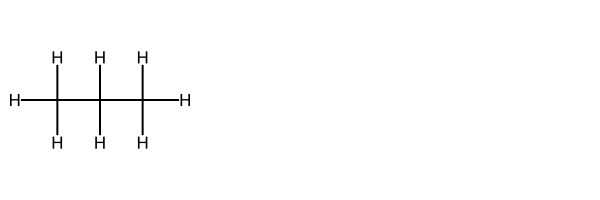

In [ ]:
from IPython.core.display import Image
from copy import deepcopy

#@title Load molecule { run: "auto" }
#@markdown Here we will load the molecule using SMILES representation. The SMILES representation can be generated at https://pubchem.ncbi.nlm.nih.gov//edit3/index.html. Copy the smiles text into this cell.

smiles = "CCC" #@param {type:"string"}


molecule_name = "molecule"
# drawing_style = "stick" #@param ['stick', 'sphere', 'line','carton']

# Establish RDKit mol object
rd_mol = Chem.MolFromSmiles(smiles)
rdmol_hs = Chem.rdmolops.AddHs(rd_mol)
rdmol_hs_2d = deepcopy(rdmol_hs)
im = Draw.MolsToGridImage([rdmol_hs])
AllChem.EmbedMolecule(rdmol_hs)
AllChem.MMFFOptimizeMolecule(rdmol_hs)
Chem.MolToXYZFile(rdmol_hs, "{}.xyz".format(molecule_name))
im

In [ ]:
%%capture
#@title Run DFT calculations

#@markdown The theory behind DFT is beyond this course. In brief, we are solving Schrodinger equation to get the energy. This process will need information about the hamiltonian operator and the wavefuntion of electron. The functional represents the form of Hamiltonian operator and the basis-set is the equation of wavefunction. The calculation will generate molecular orbitals and the wavefunctions are the atomic orbitals needed to generate the molecular orbitals.

from pyscf.prop.infrared.rhf import Infrared

functional = "HF" #@param ["HF", "B3LYP"]
basis_set = "3-21G" #@param ["3-21G","6-31G"]




# Set parameters
mol = gto.M(atom=F'{molecule_name}.xyz',  # Establish PySCF mol object
            basis = basis_set,
            verbose=0
            )


if functional == "B3LYP":
  mf = mol.KS()
  mf.xc = functional  # Set functional
else:
  mf = mol.HF()

# Run Optimization
# mol_eq = optimize(mf)
# # Save results to file
# mol_eq.tofile(F'{molecule_name}_optimization.xyz')


# Run Optimization
mol_eq = optimize(mf)
# Save results to file
mol_eq.tofile(F'{molecule_name}_opt.xyz')

print("Geometry optimization complete")
print("Starting frequecny calculations")

# run frequency calculations
mol = gto.M(atom=F'{molecule_name}_opt.xyz',  # Establish PySCF mol object
            basis = basis_set,
            verbose=0
            )

mf = mol.RHF().run()
hessian = mf.Hessian().kernel()
results = harmonic_analysis(mol, hessian)


In [ ]:
#@title Infrared Spectrum

mf_ir = Infrared(mf).run()
mf_ir.plot_ir()

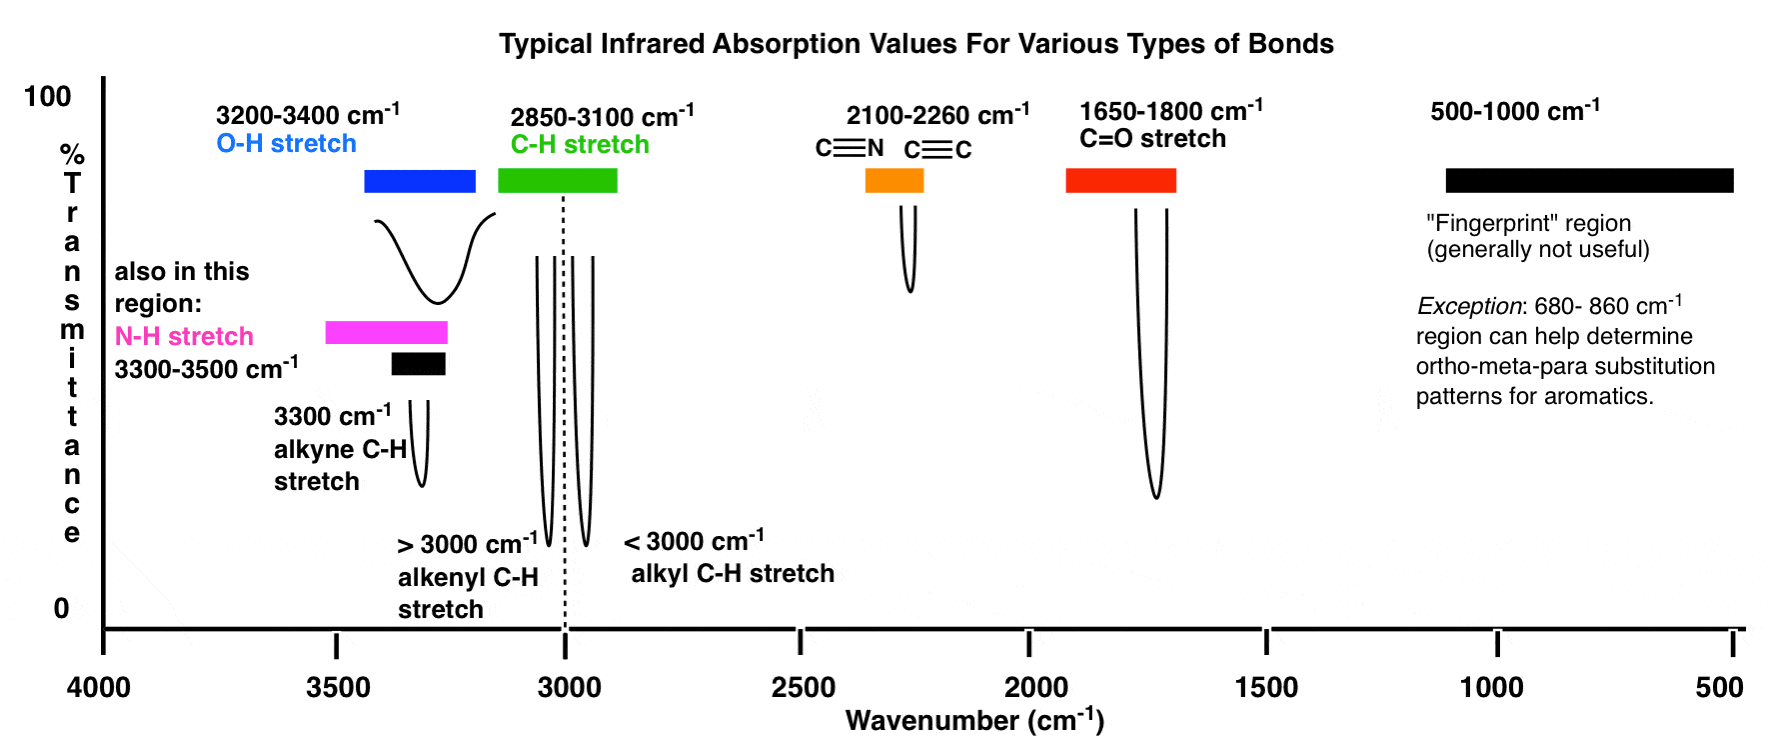

In [ ]:
#@title Select vibration to visualize
from pyscf.lib import param
d = {}

num_atoms = mol.atom_coords().__len__()
elements_list = mol.elements
freq_list = results["freq_wavenumber"]

mol_coords = mol.atom_coords() * param.BOHR

for idx, i in enumerate(freq_list):
    xyz = "{}\n".format(num_atoms)
    for atom_idx, atom in enumerate(elements_list):
      xyz += "\n{}\t{}\t{}\t{}\t{}\t{}\t{}".format(atom, round(mol_coords[atom_idx][0],3),round(mol_coords[atom_idx][1],3),round(mol_coords[atom_idx][2],3),
                                             round(results["norm_mode"][idx][atom_idx][0],3), round(results["norm_mode"][idx][atom_idx][1],3), round(results["norm_mode"][idx][atom_idx][2],3))
    d.update({int(i): xyz})

import ipywidgets as widgets

freq = widgets.Dropdown(
    options=d.items(),
    description='Number:',
)
display(freq)


In [ ]:
#@title Visualize the vibration
xyzview = py3Dmol.view()
xyzview.addModel(freq.value,'xyz',{'vibrate': {'frames':20,'amplitude':1}})
xyzview.setStyle({'stick':{}})
xyzview.animate({'loop': 'backAndForth'})
xyzview.zoomTo()
xyzview.show()

## Tasks

How do you differentiate the following set of molecules with the IR spectrum? Visualize the vibrations that aid in differentiating and indicate which atoms are involed.

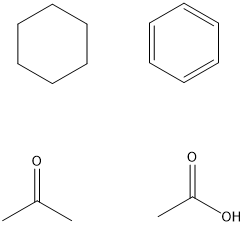
